**Constantes**

Tamanho da sequência utilizada, tamanho da janela, frequência de _cutoff_, tamanho de lote, etc.

In [1]:
BASE_VALUE = 'discharge'
BATCH_SIZE = 32
CUTOFF_FREQUENCY = 0.009
DATA_FOLDER = '../../data'
DENSE_ACTIVATION_FUNCTION = 'linear'
EARLY_STOP_EPOCH = 66
EARLY_STOP_PATIENCE = 36
EPOCHS = 200
INITIAL_LEARNING_RATE = 0.001
LEARNING_RATE_REDUCER_FACTOR = 0.5
LEARNING_RATE_REDUCER_PATIENCE = 16
LSTM_COUNT = [8]
NORMALIZE = True
NOTEBOOK_NAME = '1_only_one_layer'
PREDICTED_VALUE = 'discharge'
SAMPLE_RATE = 1
SEQUENCE_GAP = 1
SEQUENCE_SIZE = 12
TEST_SPLIT_FACTOR = 4

In [2]:
PLOT_TITLE = f'{BASE_VALUE} -> {PREDICTED_VALUE}'

In [3]:
from keras.callbacks import ReduceLROnPlateau
from tensorflow.python.platform import tf_logging as logging


class ReduceLRBacktrack(ReduceLROnPlateau):
    def __init__(self, best_path, *args, **kwargs):
        super(ReduceLRBacktrack, self).__init__(*args, **kwargs)
        self.best_path = best_path

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            logging.warning('Reduce LR on plateau conditioned on metric `%s` '
                            'which is not available. Available metrics are: %s',
                            self.monitor, ','.join(list(logs.keys())))
        if not self.monitor_op(current, self.best):  # not new best
            if not self.in_cooldown():  # and we're not in cooldown
                if self.wait+1 >= self.patience:  # going to reduce lr
                    # load best model so far
                    print("Backtracking to best model before reducting LR")
                    self.model.load_weights(self.best_path)

        super().on_epoch_end(epoch, logs)  # actually reduce LR

2023-10-27 16:35:08.151717: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-27 16:35:08.196057: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-27 16:35:08.196085: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-27 16:35:08.196103: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-27 16:35:08.201051: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-27 16:35:08.201580: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Estado para reproduzir os mesmos resultados

In [4]:
from keras.utils import set_random_seed

set_random_seed(42)

# Preparação dos dados

Carregando os arquivos .csv que contém os dados de altura da lâmina e vazão.

## Altura

In [5]:
import pandas as pd

In [6]:
depth_df = pd.read_csv(f'{DATA_FOLDER}/water_depth_reservoir_Test1.csv')
display(depth_df)

,time (s),water depth (m),Unnamed: 2
0,0,0.45045,NaN
1,1,0.45070,NaN
2,2,0.45086,NaN
3,3,0.45096,NaN
4,4,0.45100,NaN
...,...,...,...
4313,4313,0.43703,NaN
4314,4314,0.43711,NaN
4315,4315,0.43720,NaN
4316,4316,0.43729,NaN


Devido à forma como o CSV está organizado, há uma coluna extra indesejada.

Para corrigir isso, podemos dropar essa coluna utilizando pandas.

In [7]:
depth_df = depth_df.drop(columns=[depth_df.columns[-1]])
display(depth_df)

,time (s),water depth (m)
0,0,0.45045
1,1,0.45070
2,2,0.45086
3,3,0.45096
4,4,0.45100
...,...,...
4313,4313,0.43703
4314,4314,0.43711
4315,4315,0.43720
4316,4316,0.43729


Ignorando coluna com o valor do tempo, pois a coluna de índice é equivalente.

In [8]:
depth_df = depth_df.drop(columns=[depth_df.columns[0]])
display(depth_df)

,water depth (m)
0,0.45045
1,0.45070
2,0.45086
3,0.45096
4,0.45100
...,...
4313,0.43703
4314,0.43711
4315,0.43720
4316,0.43729


## Vazão

In [9]:
discharge_df = pd.read_csv(f'{DATA_FOLDER}/discharge_inlet_Test1.csv')
display(discharge_df)

,time (s),inlet discharge (m3/s)
0,1,0.000630
1,1,0.000388
2,1,0.000203
3,1,0.000070
4,4,-0.000020
...,...,...
4313,4313,0.024713
4314,4314,0.024809
4315,4315,0.024889
4316,4316,0.024951


Na coluna indicando o tempo em segundos, o valor "1" está sendo repetido 4 vezes.

Tendo em vista que os valores da vazão mudaram para essas 4 entradas, vamos assumir que isso foi um erro de registro e que os valores são na realidade 0, 1, 2, ...

Essa mudança torna esse dataset consistente com o de altura carregado anteriormente.

Da mesma forma como fizemos anteriormente, podemos tratar a coluna de índices como nosso indicador de tempo.

In [10]:
discharge_df = discharge_df.drop(columns=[discharge_df.columns[0]])
display(discharge_df)

,inlet discharge (m3/s)
0,0.000630
1,0.000388
2,0.000203
3,0.000070
4,-0.000020
...,...
4313,0.024713
4314,0.024809
4315,0.024889
4316,0.024951


Podemos unir os dados em um só DF, o que facilita a preparação dos mesmos

In [11]:
unified_df = pd.concat([discharge_df, depth_df], axis=1)
display(unified_df)

,inlet discharge (m3/s),water depth (m)
0,0.000630,0.45045
1,0.000388,0.45070
2,0.000203,0.45086
3,0.000070,0.45096
4,-0.000020,0.45100
...,...,...
4313,0.024713,0.43703
4314,0.024809,0.43711
4315,0.024889,0.43720
4316,0.024951,0.43729


## Remoção de ruídos

In [12]:
from scipy.signal import butter, filtfilt

smoothed_df = unified_df.copy()

original_discharge = smoothed_df['inlet discharge (m3/s)'].values
b, a = butter(N=6, Wn=CUTOFF_FREQUENCY/(0.5*SAMPLE_RATE), btype='low')
y = filtfilt(b, a, original_discharge)
smoothed_df['inlet discharge (m3/s)'] = y

original_depth = smoothed_df['water depth (m)'].values
b, a = butter(N=6, Wn=CUTOFF_FREQUENCY/(0.5*SAMPLE_RATE), btype='low')
y = filtfilt(b, a, original_depth)
smoothed_df['water depth (m)'] = y

Verificando resultado da remoção de ruído

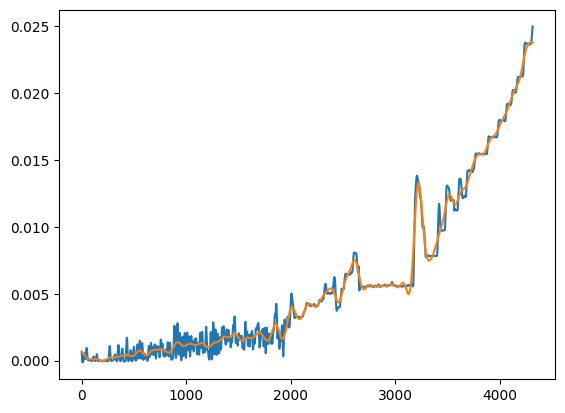

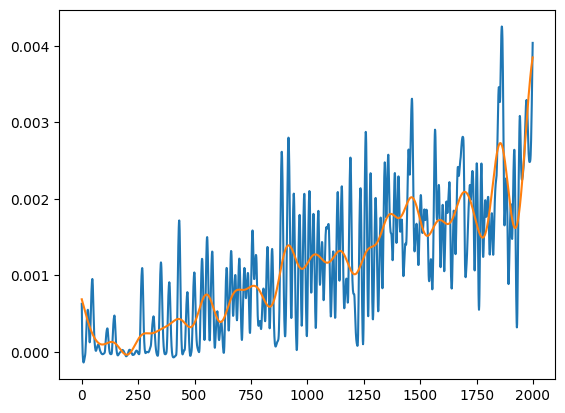

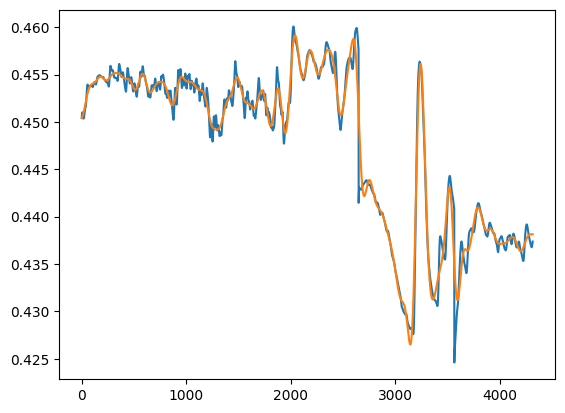

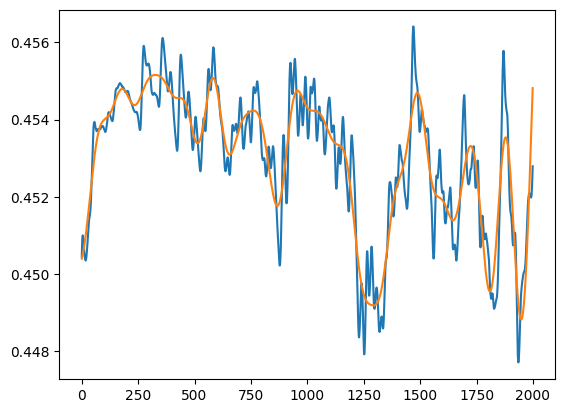

In [13]:
import matplotlib.pyplot as plt

plt.plot(unified_df['inlet discharge (m3/s)'])
plt.plot(smoothed_df['inlet discharge (m3/s)'])
plt.show()

plt.plot(unified_df['inlet discharge (m3/s)'].values[:2000])
plt.plot(smoothed_df['inlet discharge (m3/s)'].values[:2000])
plt.show()

plt.plot(unified_df['water depth (m)'])
plt.plot(smoothed_df['water depth (m)'])
plt.show()

plt.plot(unified_df['water depth (m)'].values[:2000])
plt.plot(smoothed_df['water depth (m)'].values[:2000])
plt.show()

Convertendo o DataFrame em array numpy para facilitar acesso.

In [14]:
unified = smoothed_df.to_numpy()

## Normalização

In [15]:
from sklearn.preprocessing import MinMaxScaler

unified_scaler = MinMaxScaler()
water_depth_scaler = MinMaxScaler()
inlet_discharge_scaler = MinMaxScaler()
water_depth_scaler.fit(unified[:, 1].reshape(-1, 1))
inlet_discharge_scaler.fit(unified[:, 0].reshape(-1, 1))
unified_scaler.fit(unified)

MinMaxScaler()

In [16]:
if NORMALIZE:
    if PREDICTED_VALUE == 'depth':
        OUTPUT_SCALER = water_depth_scaler
    elif PREDICTED_VALUE == 'discharge':
        OUTPUT_SCALER = inlet_discharge_scaler
    elif PREDICTED_VALUE == 'both':
        OUTPUT_SCALER = unified_scaler
    else:
        raise ValueError(f'PREDICTED_VALUE must be one of [depth, discharge, both], got {PREDICTED_VALUE}')
    unified = unified_scaler.transform(unified)

## Estrutura dos dados de treinamento

In [17]:
# Obtendo índices lower..upper
i = 0
lower = list()
upper = list()
while i + SEQUENCE_SIZE < len(unified):
    lower.append(i)
    upper.append(i + SEQUENCE_SIZE)
    print(f"[{i}, {i + SEQUENCE_SIZE})")
    i += SEQUENCE_GAP

[0, 12)
[1, 13)
[2, 14)
[3, 15)
[4, 16)
[5, 17)
[6, 18)
[7, 19)
[8, 20)
[9, 21)
[10, 22)
[11, 23)
[12, 24)
[13, 25)
[14, 26)
[15, 27)
[16, 28)
[17, 29)
[18, 30)
[19, 31)
[20, 32)
[21, 33)
[22, 34)
[23, 35)
[24, 36)
[25, 37)
[26, 38)
[27, 39)
[28, 40)
[29, 41)
[30, 42)
[31, 43)
[32, 44)
[33, 45)
[34, 46)
[35, 47)
[36, 48)
[37, 49)
[38, 50)
[39, 51)
[40, 52)
[41, 53)
[42, 54)
[43, 55)
[44, 56)
[45, 57)
[46, 58)
[47, 59)
[48, 60)
[49, 61)
[50, 62)
[51, 63)
[52, 64)
[53, 65)
[54, 66)
[55, 67)
[56, 68)
[57, 69)
[58, 70)
[59, 71)
[60, 72)
[61, 73)
[62, 74)
[63, 75)
[64, 76)
[65, 77)
[66, 78)
[67, 79)
[68, 80)
[69, 81)
[70, 82)
[71, 83)
[72, 84)
[73, 85)
[74, 86)
[75, 87)
[76, 88)
[77, 89)
[78, 90)
[79, 91)
[80, 92)
[81, 93)
[82, 94)
[83, 95)
[84, 96)
[85, 97)
[86, 98)
[87, 99)
[88, 100)
[89, 101)
[90, 102)
[91, 103)
[92, 104)
[93, 105)
[94, 106)
[95, 107)
[96, 108)
[97, 109)
[98, 110)
[99, 111)
[100, 112)
[101, 113)
[102, 114)
[103, 115)
[104, 116)
[105, 117)
[106, 118)
[107, 119)
[108, 120)

Construindo sequência de inputs e outputs utilizadas pela rede.

No caso desse notebook:

- Input: Altura da lâmina
- Output: Altura da lâmina

In [18]:
import numpy as np

number_of_sequences = len(lower)
display("Quantidade de sequências", number_of_sequences)

TRAINING_SIZE = int(number_of_sequences * (1 - 1 / TEST_SPLIT_FACTOR))
display("Quantidade de sequências de treinamento", TRAINING_SIZE)

inputs = np.zeros((number_of_sequences, SEQUENCE_SIZE, 1))
if PREDICTED_VALUE == 'both':
    outputs = np.zeros((number_of_sequences, SEQUENCE_SIZE, 2))
elif PREDICTED_VALUE == 'depth' or PREDICTED_VALUE == 'discharge':
    outputs = np.zeros((number_of_sequences, 1))
else:
    raise ValueError(f'PREDICTED_VALUE must be one of [depth, discharge, both], got {PREDICTED_VALUE}')
for i in range(number_of_sequences):
    if BASE_VALUE == 'depth':
        inputs[i, :] = unified[lower[i]:upper[i], 1].reshape(-1, 1)
    elif BASE_VALUE == 'discharge':
        inputs[i, :] = unified[lower[i]:upper[i], 0].reshape(-1, 1)
    elif BASE_VALUE == 'both':
        inputs[i, :] = unified[lower[i]:upper[i], :]
    else:
        raise ValueError(f'BASE_VALUE must be one of [depth, discharge, both], got {BASE_VALUE}')
    if PREDICTED_VALUE == 'both':
        outputs[i, :] = unified[upper[i], :]
    elif PREDICTED_VALUE == 'depth':
        outputs[i, :] = unified[upper[i], 1]
    elif PREDICTED_VALUE == 'discharge':
        outputs[i, :] = unified[upper[i], 0]
    else:
        raise ValueError(f'PREDICTED_VALUE must be one of [depth, discharge, both], got {PREDICTED_VALUE}')

inputs_train = inputs[:TRAINING_SIZE]
outputs_train = outputs[:TRAINING_SIZE]
inputs_test = inputs[TRAINING_SIZE:]
outputs_test = outputs[TRAINING_SIZE:]
display("Shapes", inputs_train.shape, outputs_train.shape,
        inputs_test.shape, outputs_test.shape)

'Quantidade de sequências'

4306

'Quantidade de sequências de treinamento'

3229

'Shapes'

(3229, 12, 1)

(3229, 1)

(1077, 12, 1)

(1077, 1)

# Rede neural e treinamento (Adam)

In [19]:
from keras.models import Sequential
from keras.layers import LSTM, InputLayer, Dense
from keras.optimizers import Adam
from keras.utils import plot_model
import os

if os.path.exists(f'{NOTEBOOK_NAME}/model.png'):
    os.remove(f'{NOTEBOOK_NAME}/model.png')

model = Sequential(name=NOTEBOOK_NAME)
model.add(InputLayer(input_shape=((None, 1)), name='input_layer'))
for i, cell in enumerate(LSTM_COUNT[:-1]):
    model.add(LSTM(cell, return_sequences=True, name=f'lstm_layer_{i + 1}'))
model.add(LSTM(LSTM_COUNT[-1], name=f'lstm_layer_{len(LSTM_COUNT)}'))
model.add(Dense(1, DENSE_ACTIVATION_FUNCTION, name=DENSE_ACTIVATION_FUNCTION))
model.summary()
opt = Adam(learning_rate=INITIAL_LEARNING_RATE, amsgrad=True)

if not os.path.exists(NOTEBOOK_NAME):
    os.mkdir(NOTEBOOK_NAME)
plot_model(model, f'{NOTEBOOK_NAME}/model.png', show_shapes=True)
model.compile(loss='mae', optimizer=opt)

2023-10-27 16:35:10.989207: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-27 16:35:10.989572: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "1_only_one_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_layer_1 (LSTM)         (None, 8)                 320       
                                                                 
 linear (Dense)              (None, 1)                 9         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

history = model.fit(
    inputs_train, outputs_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    shuffle=True,
    validation_batch_size=BATCH_SIZE//2,
    validation_split=0.15,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE,
                      verbose=1, restore_best_weights=True, start_from_epoch=EARLY_STOP_EPOCH),
        ModelCheckpoint(f'{NOTEBOOK_NAME}/model_adam.h5',
                        save_best_only=True, save_weights_only=True),
        ReduceLRBacktrack(f'{NOTEBOOK_NAME}/model_adam.h5',
                          monitor='val_loss', patience=LEARNING_RATE_REDUCER_PATIENCE, factor=LEARNING_RATE_REDUCER_FACTOR, verbose=1)
    ]
)
# Recuperando melhor modelo
model.load_weights(f'{NOTEBOOK_NAME}/model_adam.h5')

Epoch 1/200
86/86 [==============================] - 2s 8ms/step - loss: 0.0157 - val_loss: 0.0110 - lr: 0.0010
Epoch 2/200
86/86 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0104 - lr: 0.0010
Epoch 3/200
86/86 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0097 - lr: 0.0010
Epoch 4/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0099 - lr: 0.0010
Epoch 5/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0099 - lr: 0.0010
Epoch 6/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0095 - lr: 0.0010
Epoch 7/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0097 - lr: 0.0010
Epoch 8/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0084 - lr: 0.0010
Epoch 9/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0090 - lr:

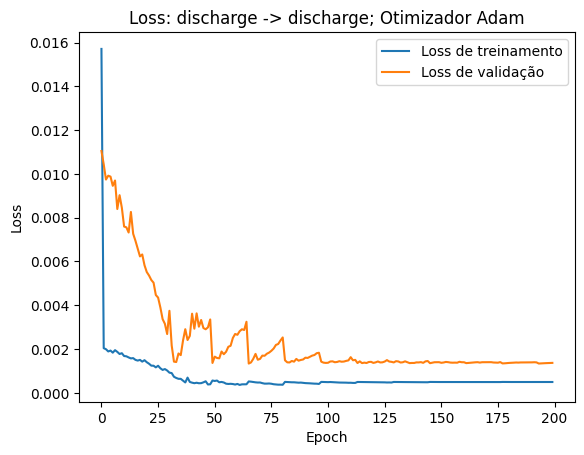

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Loss de treinamento')
plt.plot(history.history['val_loss'], label='Loss de validação')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title(f'Loss: {PLOT_TITLE}; Otimizador Adam')
plt.savefig(f'{NOTEBOOK_NAME}/loss_adam.png')

## Resultados obtidos

34/34 [==============================] - 0s 985us/step


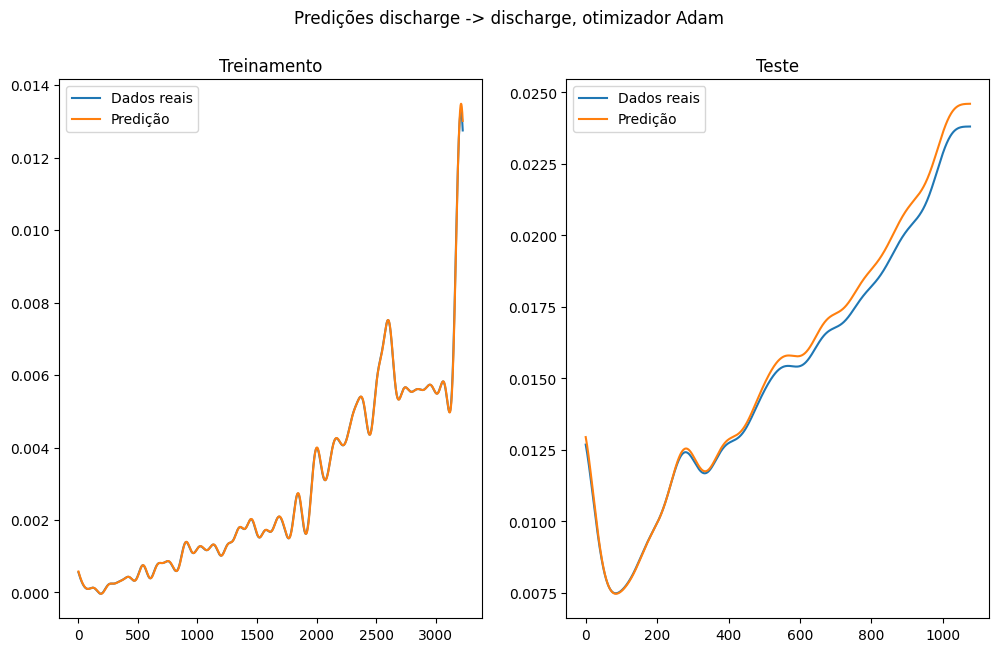

In [22]:
predictions_train = model.predict(inputs_train)
predictions_test = model.predict(inputs_test)
if NORMALIZE:
    predictions_train = OUTPUT_SCALER.inverse_transform(predictions_train)
    predictions_test = OUTPUT_SCALER.inverse_transform(predictions_test)
    temp_train = OUTPUT_SCALER.inverse_transform(outputs_train)
    temp_test = OUTPUT_SCALER.inverse_transform(outputs_test)
else:
    temp_train = outputs_train
    temp_test = outputs_test

fig, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].plot(temp_train, label='Dados reais')
ax[0].plot(predictions_train, label='Predição')
ax[0].legend()
ax[0].set_title('Treinamento')

ax[1].plot(temp_test, label='Dados reais')
ax[1].plot(predictions_test, label='Predição')
ax[1].legend()
ax[1].set_title('Teste')

fig.suptitle(f'Predições {PLOT_TITLE}, otimizador Adam')
plt.savefig(f'{NOTEBOOK_NAME}/predictions_adam.png')

# Rede neural e treinamento (SGD)

In [23]:
from keras.models import Sequential
from keras.layers import LSTM, InputLayer, Dense
from keras.optimizers import SGD

model = Sequential(name=NOTEBOOK_NAME)
model.add(InputLayer(input_shape=((None, 1)), name='input_layer'))
for i, cell in enumerate(LSTM_COUNT[:-1]):
    model.add(LSTM(cell, return_sequences=True, name=f'lstm_layer_{i + 1}'))
model.add(LSTM(LSTM_COUNT[-1], name=f'lstm_layer_{len(LSTM_COUNT)}'))
model.add(Dense(1, DENSE_ACTIVATION_FUNCTION, name=DENSE_ACTIVATION_FUNCTION))
model.summary()
opt = SGD(learning_rate=INITIAL_LEARNING_RATE, momentum=0.9)
model.compile(loss='mae', optimizer=opt)

Model: "1_only_one_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_layer_1 (LSTM)         (None, 8)                 320       
                                                                 
 linear (Dense)              (None, 1)                 9         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

history = model.fit(
    inputs_train, outputs_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    shuffle=True,
    validation_batch_size=BATCH_SIZE//2,
    validation_split=0.15,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE,
                      verbose=1, restore_best_weights=True, start_from_epoch=EARLY_STOP_EPOCH),
        ModelCheckpoint(f'{NOTEBOOK_NAME}/model_sgd.h5',
                        save_best_only=True, save_weights_only=True),
        ReduceLRBacktrack(f'{NOTEBOOK_NAME}/model_sgd.h5',
                          monitor='val_loss', patience=LEARNING_RATE_REDUCER_PATIENCE, factor=LEARNING_RATE_REDUCER_FACTOR, verbose=1)
    ]
)
# Recuperando melhor modelo
model.load_weights(f'{NOTEBOOK_NAME}/model_sgd.h5')

Epoch 1/200
86/86 [==============================] - 2s 7ms/step - loss: 0.0287 - val_loss: 0.0752 - lr: 0.0010
Epoch 2/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0177 - val_loss: 0.0421 - lr: 0.0010
Epoch 3/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0082 - lr: 0.0010
Epoch 4/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0068 - lr: 0.0010
Epoch 5/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0076 - lr: 0.0010
Epoch 6/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0071 - lr: 0.0010
Epoch 7/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0072 - lr: 0.0010
Epoch 8/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0067 - lr: 0.0010
Epoch 9/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0070 - lr:

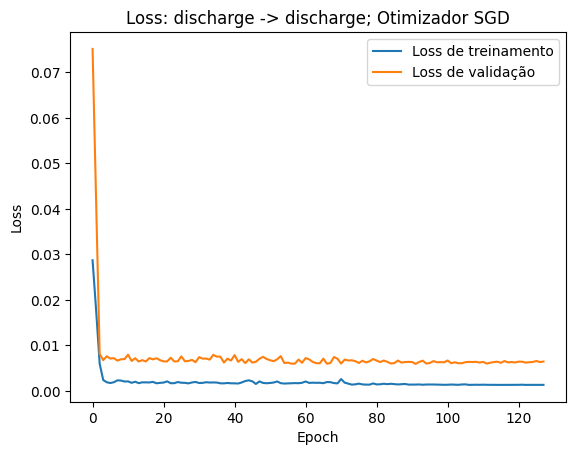

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Loss de treinamento')
plt.plot(history.history['val_loss'], label='Loss de validação')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title(f'Loss: {PLOT_TITLE}; Otimizador SGD')
plt.savefig(f'{NOTEBOOK_NAME}/loss_sgd.png')

## Resultados obtidos

Comparando predições para as sequências separadas para teste

Dados de treinamento: primeiro a rede precisa ser capaz de apresentar um desempenho satisfatório para os dados que foram utilizados em seu treinamento...

34/34 [==============================] - 0s 1ms/step


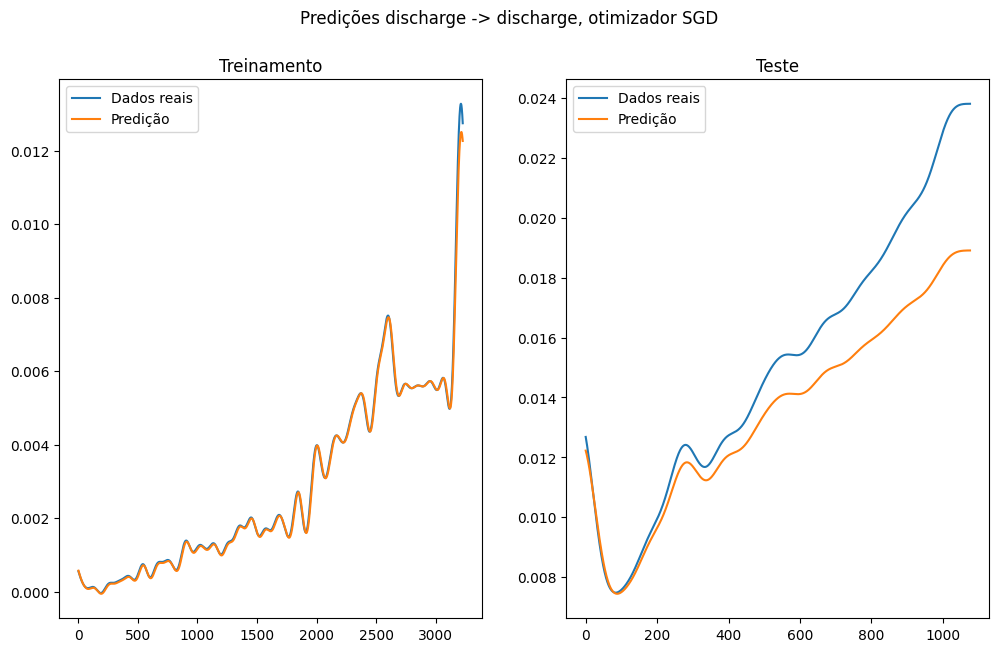

In [26]:
predictions_train = model.predict(inputs_train)
predictions_test = model.predict(inputs_test)
if NORMALIZE:
    predictions_train = OUTPUT_SCALER.inverse_transform(predictions_train)
    predictions_test = OUTPUT_SCALER.inverse_transform(predictions_test)
    temp_train = OUTPUT_SCALER.inverse_transform(outputs_train)
    temp_test = OUTPUT_SCALER.inverse_transform(outputs_test)
else:
    temp_train = outputs_train
    temp_test = outputs_test

fig, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].plot(temp_train, label='Dados reais')
ax[0].plot(predictions_train, label='Predição')
ax[0].legend()
ax[0].set_title('Treinamento')

ax[1].plot(temp_test, label='Dados reais')
ax[1].plot(predictions_test, label='Predição')
ax[1].legend()
ax[1].set_title('Teste')

fig.suptitle(f'Predições {PLOT_TITLE}, otimizador SGD')
plt.savefig(f'{NOTEBOOK_NAME}/predictions_sgd.png')